In [1]:
# Gerekli kütüphanelerin yüklenmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from torchvision import datasets, transforms

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


# Veri yükleme ve transformasyon
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.GTSRB(root="./data", split="train", download=True, transform=transform)
test_dataset = datasets.GTSRB(root="./data", split="test", download=True, transform=transform)


100%|██████████| 187M/187M [00:06<00:00, 30.2MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:03<00:00, 25.8MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 278kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [5]:
# CSV dosyasını yükleme (delimiter ";" kontrolü ile)
data = pd.read_csv("/content/data/gtsrb/GT-final_test.csv", delimiter=";")

# Eksik değer kontrolü ve temizleme
print("Eksik değerler:\n", data.isnull().sum())
data.fillna(data.select_dtypes(include='number').mean(), inplace=True)

# Özellik ve hedef ayrımı
X = data.iloc[:, :-1].values  # Son sütun hariç tüm sütunlar
y = data.iloc[:, -1].values  # Son sütun hedef

# Kontrol
print("X örnekleri:\n", X[:5])
print("y örnekleri:\n", y[:5])

Eksik değerler:
 Filename    0
Width       0
Height      0
Roi.X1      0
Roi.Y1      0
Roi.X2      0
Roi.Y2      0
ClassId     0
dtype: int64
X örnekleri:
 [['00000.ppm' 53 54 6 5 48 49]
 ['00001.ppm' 42 45 5 5 36 40]
 ['00002.ppm' 48 52 6 6 43 47]
 ['00003.ppm' 27 29 5 5 22 24]
 ['00004.ppm' 60 57 5 5 55 52]]
y örnekleri:
 [16  1 38 33 11]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Extract features (image data) and labels
X_train = [train_dataset[i][0].numpy() for i in range(len(train_dataset))]
y_train = [train_dataset[i][1] for i in range(len(train_dataset))]

X_test = [test_dataset[i][0].numpy() for i in range(len(test_dataset))]
y_test = [test_dataset[i][1] for i in range(len(test_dataset))]

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the image data to 2D for StandardScaler
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Now you can apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.25      0.33        60
           1       0.78      0.82      0.80       720
           2       0.81      0.81      0.81       750
           3       0.66      0.55      0.60       450
           4       0.69      0.72      0.71       660
           5       0.58      0.79      0.67       630
           6       0.86      0.61      0.72       150
           7       0.91      0.62      0.74       450
           8       0.75      0.72      0.73       450
           9       0.93      0.78      0.84       480
          10       0.89      0.92      0.91       660
          11       0.85      0.84      0.85       420
          12       0.92      0.93      0.93       690
          13       0.96      0.96      0.96       720
          14       0.99      0.83      0.90       270
          15       0.76      0.85      0.80       210
          16       0.96      0.81      0.88       150


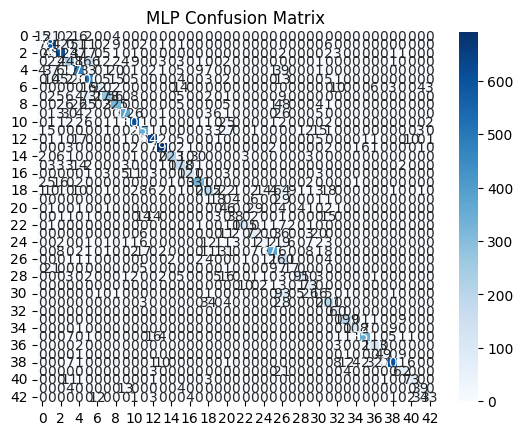

In [9]:
# MLP Modeli Tanımlama ve Eğitme
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)

# Tahminler
y_pred_mlp = mlp_model.predict(X_test)

# Performans Değerlendirme
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Karışıklık Matrisi
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.show()


In [13]:

# RBF Katmanını Tanımlama
class RBFLayer(Layer):
    def __init__(self, units, gamma=None, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma if gamma is not None else 1.0  # Gaussian gamma parametresi

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[1]),
                                       initializer='uniform',
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.units,),
                                     initializer='ones',
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs, axis=1) - self.centers
        l2 = K.sum(K.square(diff), axis=2)
        return K.exp(-self.betas * l2)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)


Epoch 1/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 88s 129ms/step - accuracy: 0.0639 - loss: 3.6636 - val_accuracy: 0.0000e+00 - val_loss: 4.2671
Epoch 2/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - accuracy: 0.0694 - loss: 3.4035 - val_accuracy: 0.0000e+00 - val_loss: 4.7470
Epoch 3/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 97s 145ms/step - accuracy: 0.0700 - loss: 3.2911 - val_accuracy: 0.0000e+00 - val_loss: 5.1709
Epoch 4/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 87s 131ms/step - accuracy: 0.0688 - loss: 3.2409 - val_accuracy: 0.0000e+00 - val_loss: 5.5445
Epoch 5/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 142s 131ms/step - accuracy: 0.0686 - loss: 3.2129 - val_accuracy: 0.0000e+00 - val_loss: 5.8817
395/395 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
RBF Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       720
           2       0.06      1.00      0.11       750
           3       0.00      0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


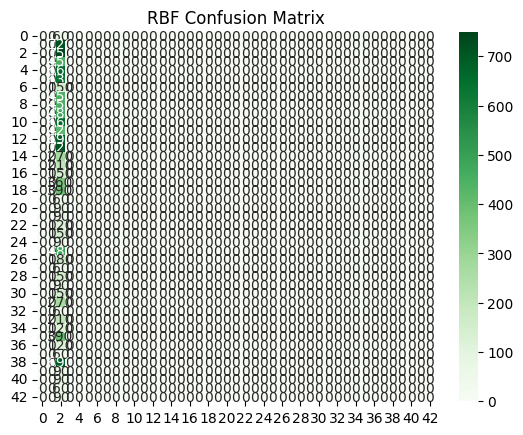

In [17]:
# RBF Modeli Tanımlama ve Eğitme
rbf_model = Sequential()
rbf_model.add(Input(shape=(X_train.shape[1],)))
#rbf_model.add(Dense(100, activation='rbf'))
rbf_model.add(RBFLayer(100, gamma=1.0))  # RBF Katmanı
rbf_model.add(Dense(len(np.unique(y)), activation='softmax'))

rbf_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rbf_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Tahminler
y_pred_rbf = np.argmax(rbf_model.predict(X_test), axis=1)

# Performans Değerlendirme
print("RBF Classification Report:")
print(classification_report(y_test, y_pred_rbf))

# Karışıklık Matrisi
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Greens')
plt.title("RBF Confusion Matrix")
plt.show()


In [19]:


param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(MLPClassifier(max_iter=10), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

En iyi parametreler: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Model  Accuracy  Precision    Recall  F1-Score
0   MLP  0.775139   0.802515  0.775139  0.779352
1   RBF  0.059382   0.003526  0.059382  0.006657


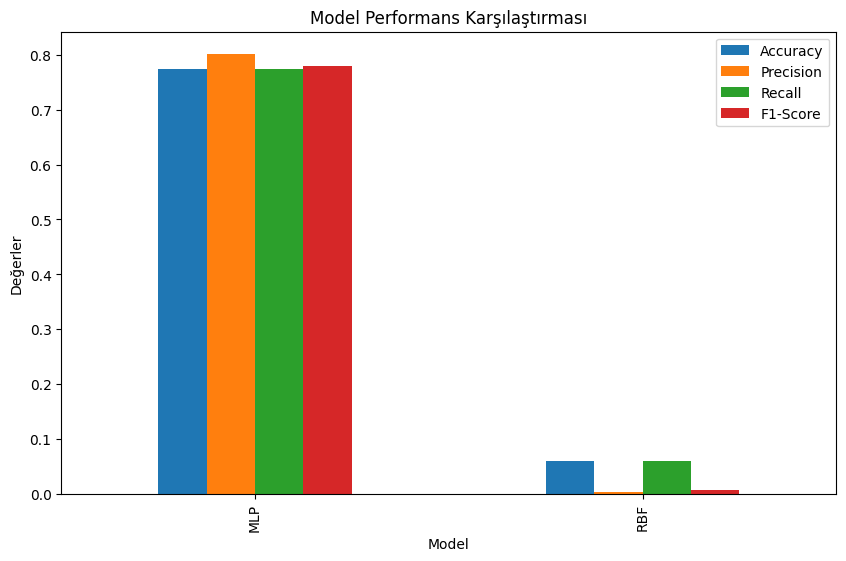

In [23]:


# Sonuçların Karşılaştırılması
results = {
    'Model': ['MLP', 'RBF'],
    'Accuracy': [accuracy_score(y_test, y_pred_mlp), accuracy_score(y_test, y_pred_rbf)],
    'Precision': [precision_score(y_test, y_pred_mlp, average='weighted'),
                  precision_score(y_test, y_pred_rbf, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_mlp, average='weighted'),
               recall_score(y_test, y_pred_rbf, average='weighted')],
    'F1-Score': [f1_score(y_test, y_pred_mlp, average='weighted'),
                 f1_score(y_test, y_pred_rbf, average='weighted')]
}

results_df = pd.DataFrame(results)
print(results_df)

# Bar Grafik
results_df.plot(x='Model', kind='bar', figsize=(10, 6))
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Değerler")
plt.show()
